In [1]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import os 
from matplotlib.patches import Polygon, FancyArrowPatch    # 用于画箭头的 ， 虽然没用到
from shapely.geometry import Polygon as ShapelyPolygon     # 用于确定多边形中心点位置
# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [163]:
"""
# 考虑了：
#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  
#     面积: 大于4e4 km^2
#     椭圆: 主轴长>100km 且 离心率大于0.4 

# 注意：
#      椭圆和对应的长轴没有画在图上 , 最后最好把轮廓也画上这样方便比较
#      覆盖面积还需要再想想， 也就是 split 和 merge
#      对单个时间的没有做融合， 因为取出的是外轮廓  

"""

'\n# 考虑了：\n#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  \n#     面积: 大于4e4 km^2\n#     椭圆: 主轴长>100km 且 离心率大于0.4 \n\n# 注意：\n#      椭圆和对应的长轴没有画在图上 , 最后最好把轮廓也画上这样方便比较\n#      覆盖面积还需要再想想， 也就是 split 和 merge\n#      对单个时间的没有做融合， 因为取出的是外轮廓  \n\n'

In [2]:
""" 
获取的数据：
    亮温： tbdata 
    经度： lon 
    纬度： lat 
"""
dir_pth = r"./data/"
all_datafiles_pth_list = os.listdir(dir_pth)
init_data_list  = []
tb_data_list = []
for i_file_pth in all_datafiles_pth_list:
    print(dir_pth+i_file_pth)
    i_file_data = xr.open_dataset(dir_pth+i_file_pth)
    # 处理单个文件数据 
    i_file_data  =  i_file_data.sel(lat = slice(-10, 30), lon = slice(90, 180)  )  
    # i_file_data  =  i_file_data.sel(lat = slice(-60, 60), lon = slice(90, 180)  )  

    tbdata = i_file_data.irwin_cdr[0].to_numpy()   # 由于获取的数据是（1，lon, lat) 所有需转换成（lon, lat)， 且为numpy格式

    # 保存的数据
    init_data_list.append(i_file_data)    
    tb_data_list.append(tbdata)

lon = i_file_data.lon    # 每个文件的lon, lat 都一样，此处取第一个文件的lon, lat
lat = i_file_data.lat   


./data/GRIDSAT-B1.2023.07.23.03.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.06.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.09.v02r01.nc


# 连续区域识别 

## 找出需要的亮温区对应轮廓

In [3]:
# 找边界
def get_outline_contour(tb): 
    """
    tb: 亮温数据，  二维numpy数组
    return: 

    """
    # 找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # # 使用形态学膨胀操作扩展冷云区域、冷云核心，   也就是把边缘弄得精细一些。   
    # kernel = np.ones((1,1), np.uint8)  
    # cold_cores = cv2.dilate(cold_cores, kernel, iterations= 1)
    # cold_regions = cv2.dilate(cold_regions, kernel, iterations= 1)

    #按照 冷区 获取轮廓
    contours_cold_cores, _ = cv2.findContours(cold_cores, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_cold_regions, _ = cv2.findContours(cold_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 准备一个掩膜用于保存需要保留的cold_regions轮廓
    all_cnts = []
    Tb_mask = np.zeros_like(cold_regions)
    for region_contour in contours_cold_regions:
        for core_contour in contours_cold_cores:
            # 检查cold_cores的轮廓是否在cold_regions的轮廓内部    ， # core_contour[0][0]是np array, 不是list
            dist = cv2.pointPolygonTest(region_contour, tuple(core_contour[0][0].tolist()), measureDist=False)
            if dist >= 0:  # 如果core_contour的一个点在region_contour内（包括边界）
                # 绘制这个cold_regions轮廓到掩膜上
                cv2.drawContours(Tb_mask, [region_contour], -1, color=255, thickness=cv2.FILLED)

                # 保存轮廓点list
                all_cnts.append(region_contour)
                # 保存单独轮廓
                # single_mask = np.zeros_like(cold_regions)
                # cv2.drawContours(single_mask, [region_contour], -1, color=255, thickness=cv2.FILLED)
                # single_mask=  single_mask.astype(bool)
                # single_mask &= (tb< 241)
                # individual_masks.append(single_mask)
                break  # 一旦找到匹配，跳出循环检查下一个cold_regions轮廓
    tbcondition = ((Tb_mask==255) & (tb < 241))
    Tb_mask = np.where(tbcondition, Tb_mask, 0)
    return Tb_mask , all_cnts

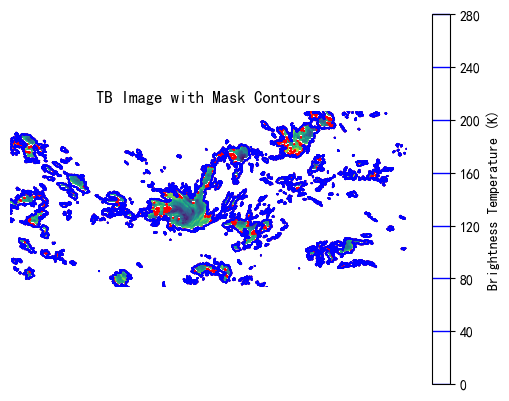

In [41]:
# # 拿出轮廓
# Tb_mask, all_cnts  = get_outline_contour(tb_data_list[0])
# cnts, _ = cv2.findContours(Tb_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 
# 
# cnt_mask = np.zeros_like(tb_data_list[0])
# for i_cnt in cnts:
#     cv2.drawContours(cnt_mask, [i_cnt], -1, 255,thickness=cv2.FILLED )
# 
# # 画图
# # img = cv2.drawContours(img, cnts, -1, (0, 255, 0), 2)
# # 假设 tb_data_list[0] 是二维数组
# plt.figure()
# plt.imshow(np.where(Tb_mask,tb_data_list[0], np.nan), cmap='viridis')  # 显示原始亮温数据
# plt.contour(Tb_mask, colors='red', linewidths=1)  # 叠加 Tb_mask 的轮廓线
# 
# plt.contour(cnt_mask, colors='blue', linewidths=1)
# 
# plt.colorbar(label='Brightness Temperature (K)')
# plt.title("TB Image with Mask Contours")
# plt.axis('off')
# plt.show()
# 


## 判断面积


In [166]:
# def judge_area(otline_mask, real_area_threshold= 4e4):
#     jg_pixel_threshold = real_area_threshold/(8*8)   #  1 pixel = 8*8 km^2 
#     filtered_contours, _ = cv2.findContours(otline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours_pts_list = []
#     for cnt in filtered_contours:
#         if cv2.contourArea(cnt) > jg_pixel_threshold:
#             contours_pts_list.append(cnt)
#     return contours_pts_list  

In [167]:
# def judge_area(otline_mask, real_area_threshold=4e4):
#     filtered_contours, _ = cv2.findContours(otline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours_pts_list = []
#     for cnt in filtered_contours:   
#         # 获取cnt掩码
#         cnt_mask = np.zeros_like(otline_mask)
#         cv2.drawContours(cnt_mask, [cnt], -1, color=255, thickness=cv2.FILLED)
#         # 根据条件创建新的掩膜
#         condition = (otline_mask == 255) & (cnt_mask == 255)
#         gt_than_4e4_mask = np.where(condition, cnt_mask, 0)

#         # 计算符合条件的面积
#         area = cv2.countNonZero(gt_than_4e4_mask)
        
#         if area > real_area_threshold:
#             contours_pts_list.append(cnt)

#     return contours_pts_list

In [4]:
def judge_area(judge_tb_mask, all_cnts, real_area_threshold=4e4):
    jg_pixel_threshold = real_area_threshold / (8 * 8)   # 1 pixel = 8*8 km^2 
    contours_pts_list = [] 
    judge_area_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
    for cnt in all_cnts:
        i_cnt_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
        cv2.drawContours(i_cnt_mask, [cnt], -1, color=255, thickness=cv2.FILLED)
        # 判断面积 
        conditon = np.logical_and(judge_tb_mask, i_cnt_mask).astype(np.uint8)
        area = cv2.countNonZero(conditon)
        if area > jg_pixel_threshold:
            contours_pts_list.append(cnt)
            cv2.drawContours(judge_area_mask, [cnt], -1, color=255, thickness=cv2.FILLED)
    return  judge_area_mask, contours_pts_list,

In [53]:
""" 下方函数未使用 """
def refine_contours(tb, judge_tb_mask, all_cnts):
    refined_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
    refined_cnts = []

    for cnt in all_cnts:
        # Step 1: 创建当前轮廓的mask
        cnt_mask = np.zeros_like(tb, dtype=np.uint8)
        cv2.drawContours(cnt_mask, [cnt], -1, color=255, thickness=cv2.FILLED)

        # Step 2: 获取当前轮廓内的像素坐标 (y, x)
        pts = np.column_stack(np.where(cnt_mask > 0))

        # Step 3: 检查这些点是否满足 tb[y, x] < 241
        valid_pts = []
        for y, x in pts:
            if tb[y, x] < 241:
                valid_pts.append([x, y])  # OpenCV 使用 (x, y) 格式保存点

        # Step 4: 如果有效点太少，跳过该轮廓， 其实找面积的时候已经保证了点的数量。 
        if len(valid_pts) < 3:
            continue

        # Step 5: 将有效点转为 NumPy 数组
        valid_pts = np.array(valid_pts, dtype=np.int32)
        # Step 7: 更新新的mask和轮廓列表 
        contour = valid_pts.reshape((-1, 1, 2))  # 新排序这些点，使其形成一个闭合轮廓（按原顺序即可）
                                             # 注意：OpenCV 的 drawContours 要求输入的点是一个 shape 为 (n, 1, 2) 的数组， 所以我们 reshape 成 (n, 1, 2)
        cv2.drawContours(refined_mask, [contour], -1, 255, thickness=cv2.FILLED)
        refined_cnts.append(contour)
        # 构建新多边形/轮廓 ==> 使用函数cv2.convexHull构建
        # # valid_pts = np.array(valid_pts, dtype=np.int32)
        # # hull = cv2.convexHull(valid_pts)  # 或者使用 approxPolyDP 简化形状
        
    return refined_mask, refined_cnts


## 椭圆（放在后面判断）

In [88]:
# 拟合长轴
def judge_ellipse(otline_pts_list):
    mch_elip_area_list  = []
    count_unfit_elip = 0
    for cnt in otline_pts_list:
        if len(cnt) >= 5: # 确保有足够数量的点来拟合椭圆
            ellipse = cv2.fitEllipse(cnt)
            
            # 判断主长轴、离心率
            major_axis_legth = max(ellipse[1][0], ellipse[1][1])
            minor_axis_legth = min(ellipse[1][0], ellipse[1][1])
            # 离心率计算
            ecc = np.sqrt(1 - (minor_axis_legth / major_axis_legth)**2)
            if (major_axis_legth > (100/8)) or (ecc > 0.4):    # 1 pixel = 8km
                mch_elip_area_list.append(cnt)
        else:
            count_unfit_elip += 1
            print("统计无法拟合椭圆的轮廓数：", count_unfit_elip)
    return  mch_elip_area_list


## 轮廓点转换为经纬度(待使用)

In [169]:
def outline2lonlat(otline_pts_list, lon , lat ):
    lonlat_pts_list = []
    for i_outline in otline_pts_list:
        # print(i_outline.squeeze().shape)
        # print("print(print(i_outline.squeeze()))")
        # print(print(i_outline.squeeze()))
        # print("==================================")
        
        i_new_list = []
        for i_lonlat in i_outline.squeeze():   #  [x  y] 的一个点  
            i_lon = lon[i_lonlat[0]].item()
            i_lat = lat[i_lonlat[1]].item()
            i_new_list.append([i_lon, i_lat]) 
        lonlat_pts_list.append(i_new_list)
    return lonlat_pts_list

## 将轮廓点转化为对应的掩码和真实数据

In [16]:
def get_dataAndmask(outline_mask, matched_outline_list, initdata):
    result_mask = np.zeros_like(outline_mask)   
    for i_outline_3Dpts in matched_outline_list:
        cv2.drawContours(result_mask, [i_outline_3Dpts], -1, color=255, thickness=cv2.FILLED)
    data = np.where(result_mask, initdata, np.nan  )  # result_mask中的元素为0或者255，0也就是False, 所以mask可以作为掩码
    return  data , result_mask 

# 云的移动追踪

In [171]:
"""该函数未使用"""
# def calculate_overlap(contour1, contour2, tb):
#     """
#     计算两个轮廓之间的重叠比例（intersection / area of contour1）
#     :param contour1: 轮廓1
#     :param contour2: 轮廓2
#     :param shape: 图像尺寸 (height, width)
#     :return: overlap ratio
#     """
#     mask1 = np.zeros(tb.shape, dtype=np.uint8)
#     mask2 = np.zeros(tb.shape, dtype=np.uint8)
#     cv2.drawContours(mask1, [contour1], -1, color=1, thickness=cv2.FILLED)
#     cv2.drawContours(mask2, [contour2], -1, color=1, thickness=cv2.FILLED)



#     intersection = np.logical_and(mask1, mask2).sum()
#     area1 = cv2.contourArea(contour1)
#     area2 = cv2.contourArea(contour2)
#     ration = intersection/min(area1, area2)
#     return ration

In [49]:
def calculate_overlap(contour1, contour2, tb):
    """
    计算两个轮廓之间的重叠比例（intersection / area of contour1），仅考虑tb<241的区域。
    :param contour1: 轮廓1, 表示以前时刻
    :param contour2: 轮廓2， 表示当前时刻
    :param tb: 输入的真实数据数组
    :return: overlap ratio
    """
    mask1 = np.zeros(tb.shape, dtype=np.uint8)
    mask2 = np.zeros(tb.shape, dtype=np.uint8)
    
    # 绘制轮廓到掩膜上
    cv2.drawContours(mask1, [contour1], -1, color=1, thickness=cv2.FILLED)
    cv2.drawContours(mask2, [contour2], -1, color=1, thickness=cv2.FILLED)

    # 将不满足tb < 241的区域从掩膜中排除
    mask1 &= (tb < 241)
    mask2 &= (tb < 241)

    # 计算交集和各自的面积
    intersection = np.logical_and(mask1, mask2).sum()
    area1 = mask1.sum()  # 因为mask1是二值化的，可以直接用sum来计算面积
    area2 = mask2.sum()

    # if min(area1, area2) > 0:
    #     ratio = intersection / min(area1, area2)
    # else:
    #     ratio = 0  # 避免除以0的情况
    ratio = intersection / min(area1, area2)
    return ratio , area1 

In [12]:
# """  原版追踪  """
# def track_clouds(contours_list, tb_datalist):
#     """
#     :param contours_list: list[list[contours]]，每个元素是一帧中的多个轮廓
#     :return: tracked_contours: 每个轮廓带有一个ID
#     """
#     tracked_contours = []  # 存储每帧的 (contour, id) 列表
#     current_id = 0

#     for i, frame_contours in enumerate(contours_list):
#         current_tracked = []   
#         if i == 0:
#             # 第一帧所有轮廓都是新ID
#             for cnt in frame_contours:
#                 current_tracked.append((cnt, current_id))
#                 current_id += 1  
#         else:
#             prev_tracked = tracked_contours[i - 1]
#             used_idx = set()
#             for cnt in frame_contours:
#                 best_ratio = 0
#                 best_id = None

#                 for j, (prev_cnt, pid) in enumerate(prev_tracked): #  
#                     if j in used_idx:
#                         continue
#                     overlap_ratio = calculate_overlap(prev_cnt, cnt, tb_datalist[i])
#                     if   overlap_ratio >= 0.5  and overlap_ratio > best_ratio:
#                         best_ratio = overlap_ratio
#                         best_id = pid

#                 if best_id is not None:
#                     used_idx.add(j)
#                     current_tracked.append((cnt, best_id)) 
#                 else:
#                     # 新云团
#                     current_tracked.append((cnt, current_id))
#                     current_id += 1

#         tracked_contours.append(current_tracked)

#     return tracked_contours  

In [51]:
"""   考虑前一时刻最大面积的追踪 函数"""
def track_clouds(contours_list, tb_datalist):
    """
    :param contours_list: list[list[contours]]，每个元素是一帧中的多个轮廓
    :return: tracked_contours: 每个轮廓带有一个ID
    """
    tracked_contours = []  # 存储每帧的 (contour, id) 列表
    current_id = 0

    for i, frame_contours in enumerate(contours_list):
        current_tracked = []

        if i == 0:
            # 第一帧：所有轮廓都是新ID
            for cnt in frame_contours:
                current_tracked.append((cnt, current_id))
                current_id += 1

        else:
            prev_tracked = tracked_contours[i - 1]
            used_idx = set()  # 已匹配的前一帧轮廓索引

            for cnt in frame_contours:
                candidates = []  # 存储所有满足 overlap_ratio ≥ 0.5 的匹配项

                for j, (prev_cnt, pid) in enumerate(prev_tracked):
                    if j in used_idx:
                        continue

                    # 调用你自己的 calculate_overlap
                    overlap_ratio, area1 = calculate_overlap(prev_cnt, cnt, tb_datalist[i])

                    if overlap_ratio >= 0.5:
                        # 同时保存 j（索引）、pid（ID）、area1（前一帧轮廓的有效面积）
                        candidates.append((j, pid, area1))

                if candidates:
                    # 按面积从大到小排序，取最大面积的那个
                    best_j, best_pid, _ = sorted(candidates, key=lambda x: x[2], reverse=True)[0]
                    used_idx.add(best_j)
                    current_tracked.append((cnt, best_pid))
                else:
                    # 没有匹配项 → 新云团
                    current_tracked.append((cnt, current_id))
                    current_id += 1

        tracked_contours.append(current_tracked)

    return tracked_contours

# 测试数据

In [8]:
# 数据部分,  使用cnt不是很准确， 现在让return都是mask 
# mask 也不行， 因为对每个轮廓的处理需要用到  cnt 单独拿出来。 
tb_mask, all_cnts = get_outline_contour(tb_data_list[0])
judge_area_mask, contours_pts_list  = judge_area( tb_mask, all_cnts)
test_data = np.where(judge_area_mask, tb_data_list[0], np.nan  ) 

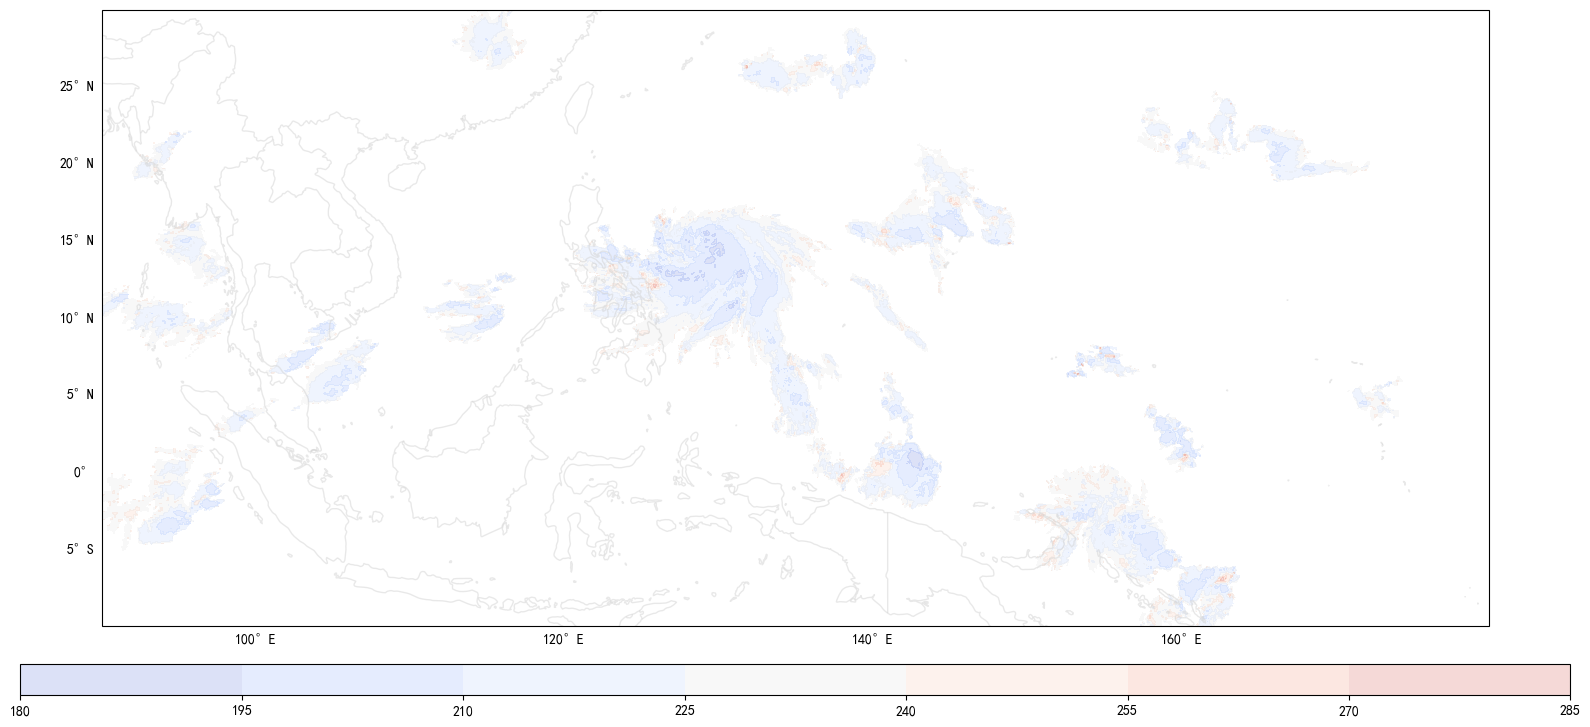

In [9]:
# 画图
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

cmaplist = [ 'Reds', 'Greens','Blues']

color_list = ['gray', 'darkblue', 'darkred']

for i_t in range(1):
    img = ax.contourf(lon,lat , test_data, 
                cmap='coolwarm', 
                alpha =  0.2,
                transform=ccrs.PlateCarree())
# colorbar 
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
plt.show()

# 正式数据

In [6]:
# 获取不同时刻的完整轮廓
contours_list = []  # 存储每个时刻的轮廓列表
for tb in tb_data_list:
    outline_mask ,all_cnts = get_outline_contour(tb)  # 和 tb单个文件的shape 一样
    judge_area_mask, contours_pts_list = judge_area(outline_mask, all_cnts)
    # mch_area_elip_list   = judge_ellipse(contours_pts_list)
    contours_list.append(contours_pts_list)


In [52]:
# 开始追踪
tracked_contours  =  track_clouds(contours_list, tb_data_list) 

In [39]:
"""  原版追踪结果， 不挑选 > 2条的数据"""
# 追踪后的数据
# 第一步：按ID分组，并记录每个ID在哪些时间帧中出现过  
id_dict = {}
for t, frame in enumerate(tracked_contours):
    for contour, cid in frame:
        if cid not in id_dict:
            id_dict[cid] = []  # 初始化该ID的列表
        id_dict[cid].append({
            't': t,
            'contour': contour
        })

#  未做==>  第二步：筛选出存在 ≥2 个时刻的云团，并以 {cid: {t: contour}} 的形式保存

t_dict = {}
for id in id_dict.keys():
    items = id_dict[id]
    for item in items:
        t = item['t']
        cnt = item['contour']
        if t not in t_dict:
            t_dict[t] = []
        t_dict[t].append({
            'id': id,
            'contour': cnt
        })

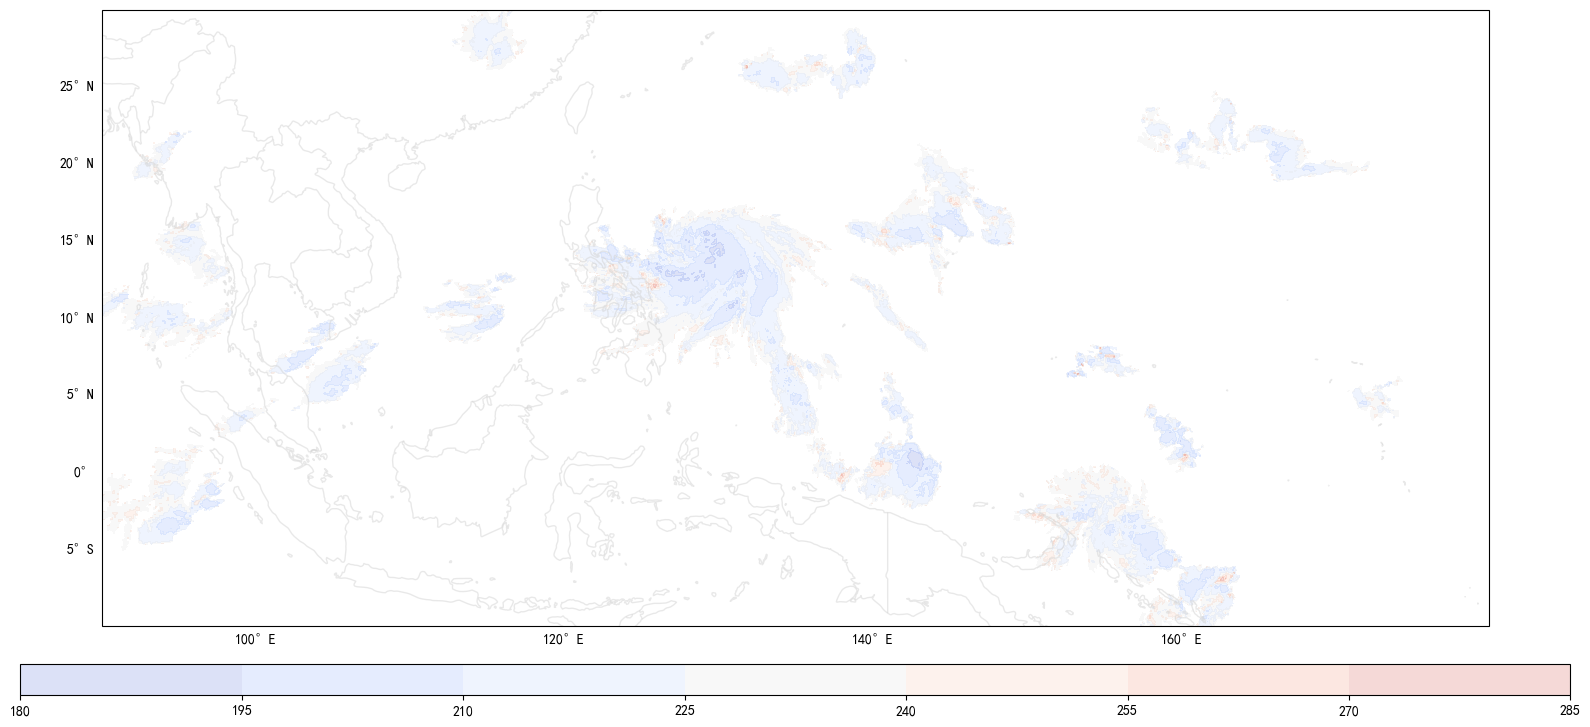

In [95]:
# # 追踪前的轮廓值转化为掩码
# 
# data_test , result_mask_test = get_dataAndmask(outline_mask, contours_list[0], tb_data_list[0])
# # 画图
# fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
# grid = ax.gridlines(draw_labels=True,linewidth=0 )
# grid.top_labels = False
# grid.right_labels = False
# ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
# ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# # ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())
# 
# cmaplist = [ 'Reds', 'Greens','Blues']
# 
# color_list = ['gray', 'darkblue', 'darkred']
# 
# for i_t in range(1):
#     img = ax.contourf(lon,lat , data_test, 
#                 cmap='coolwarm', 
#                 alpha =  0.2,
#                 transform=ccrs.PlateCarree())
# # colorbar 
# cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
# plt.show()


In [54]:
"""  挑选出同一个ID的时刻数 ≥2 个时刻的云团"""
# 第一步：按ID分组，并记录每个ID在哪些时间帧中出现过  
id_dict = {}
for t, frame in enumerate(tracked_contours):
    for contour, cid in frame:
        if cid not in id_dict:
            id_dict[cid] = []  # 初始化该ID的列表
        id_dict[cid].append({
            't': t,
            'contour': contour
        })

# 第二步：筛选出存在 ≥2 个时刻的云团，并以 {cid: {t: contour}} 的形式保存

t_dict = {}
for id in id_dict.keys():
    items = id_dict[id]
    if len(items) >= 2:
        for item in items:
            t = item['t']
            cnt = item['contour']
            if t not in t_dict:
                t_dict[t] = []
            t_dict[t].append({
                'id': id,
                'contour': cnt
            })

In [56]:
track_otlin_list = []
clean_otline_data = []
for i_t in t_dict.keys():
    i_t_track_otlin_list = []
    for i in range(len(t_dict[i_t])):
        cnt = t_dict[i_t][i]['contour']
        i_t_track_otlin_list.append(cnt)
    data , result_mask = get_dataAndmask(outline_mask, i_t_track_otlin_list, tb_data_list[i_t])
    data = np.where(data < 241, data, np.nan)
    # 保存数据
    clean_otline_data.append(data)
    track_otlin_list.append(i_t_track_otlin_list)


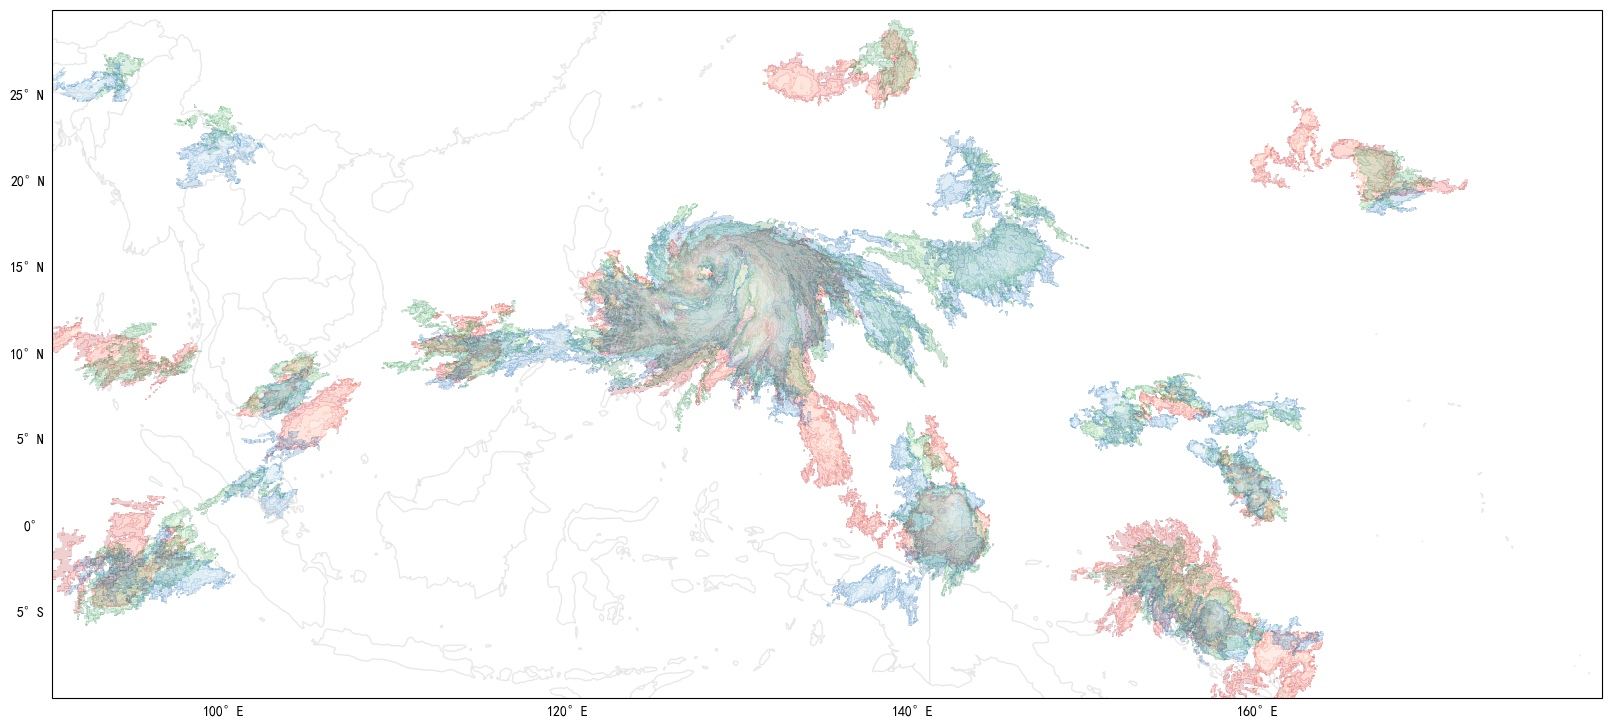

In [57]:
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

# cmap_list = ["binary", 'Blues', 'Reds']
cmaplist = [ 'Reds', 'Greens','Blues']

color_list = ['gray', 'darkblue', 'darkred']

for i_t in range(len(clean_otline_data)):
    ax.contourf(lon,lat , clean_otline_data[i_t ], 
                cmap=cmaplist[i_t], 
                alpha =  0.2,
                transform=ccrs.PlateCarree())
plt.show()



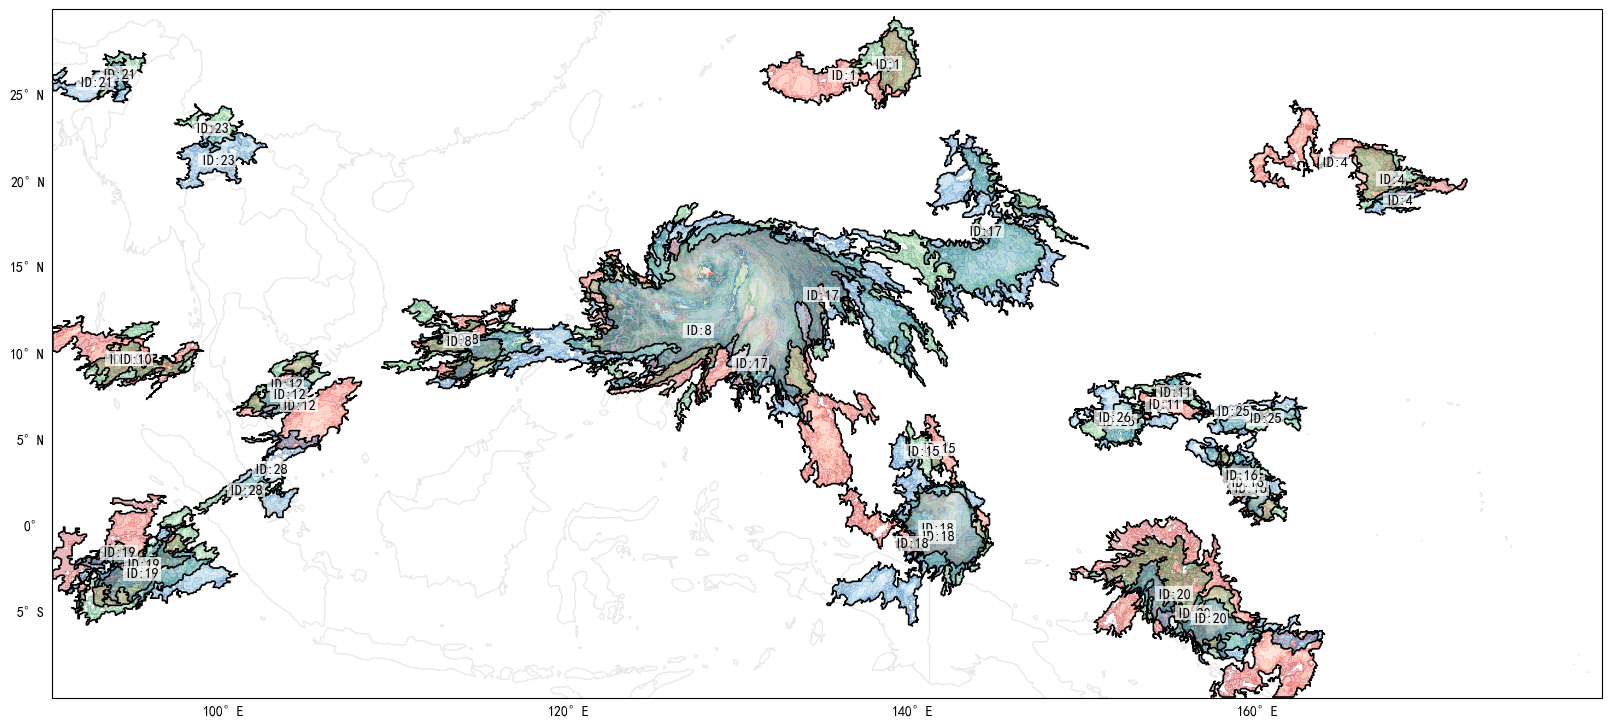

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设你已经有了：
# tracked_contours: track_clouds 返回的结果
# tb_data_list: 所有亮温数据 (list of 2D arrays)
# lon, lat: 经纬度网格数组
# clean_otline_data: 每帧中筛选后的有效数据（用于颜色填充）
# t_dict: 后处理后得到的数据结构，包含 {t: [{'id': id, 'contour': contour}, ...]}

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True, linewidth=0)
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())

cmaplist = ['Reds', 'Greens', 'Blues']

for i_t in range(len(clean_otline_data)):
# for i_t in range(1,2):
    # 绘制背景数据（可选）
    data = clean_otline_data[i_t]
    cs = ax.contourf(lon, lat, data, cmap=cmaplist[i_t % len(cmaplist)], alpha=0.3,
                     transform=ccrs.PlateCarree())


    for item in t_dict[i_t]:
        cid = item['id']
        cnt = item['contour']

        # 轮廓点坐标是 OpenCV 格式：[[[x1,y1]], [[x2,y2]], ...] → 提取为 (x, y)
        x_list = [pt[0][0] for pt in cnt]
        y_list = [pt[0][1] for pt in cnt]

        for i in range(len(x_list)):
            x_list[i] = lon[x_list[i]].item()
        for i in range(len(y_list)):
            y_list[i] = lat[y_list[i]].item()

        cx = np.mean(x_list)  # 轮廓中心横坐标
        cy = np.mean(y_list)



        # 在图上绘制轮廓线
        ax.plot(x_list, y_list, color='black', linewidth=1.2, transform=ccrs.PlateCarree())

        # 在轮廓中心绘制文本标签
        ax.text(cx, cy, f'ID:{cid}', fontsize=10, color='black',
                ha='center', va='center', weight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                transform=ccrs.PlateCarree())
    

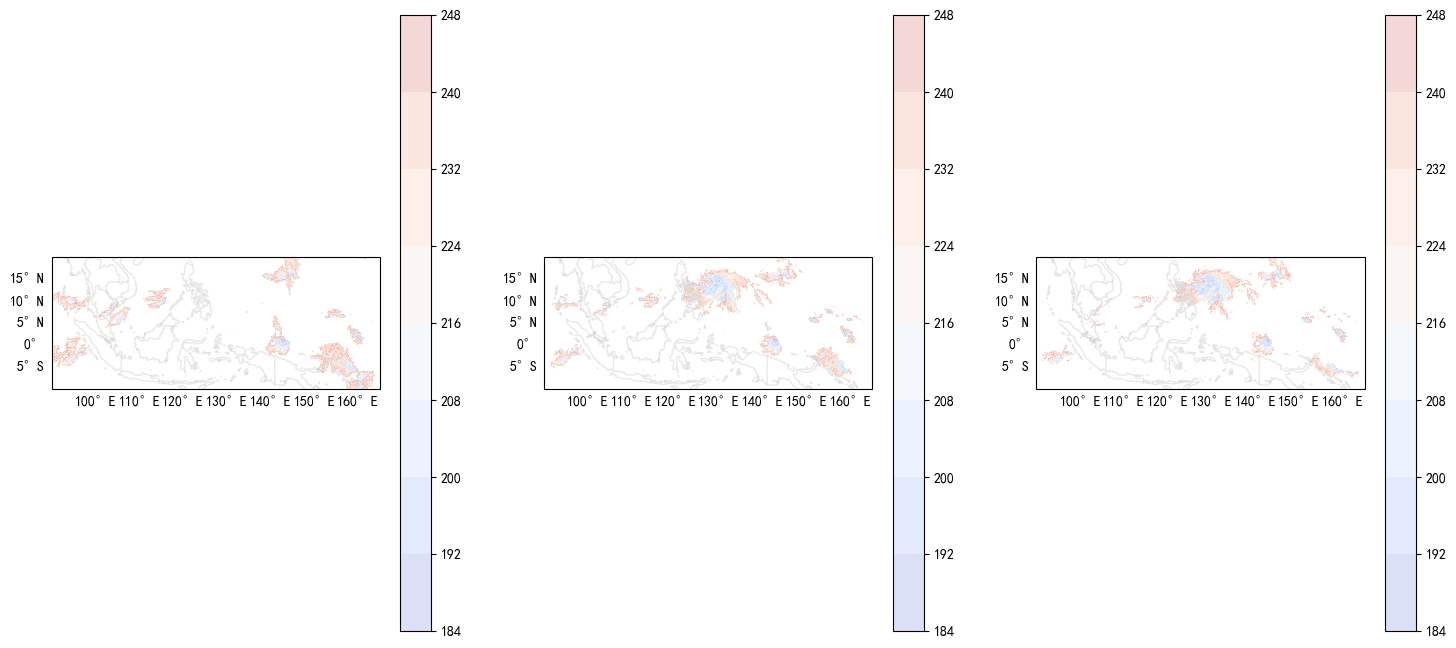

In [102]:

fig, axes = plt.subplots(1,3 , figsize=(18,10), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
cmap_list = ["binary", 'Blues', 'Reds']
color_list = ['gray', 'darkblue', 'darkred']

# 原图

# 轮廓填充图
for i, ax in enumerate(axes.flatten()):
    grid = ax.gridlines(draw_labels=True,linewidth=0 )
    grid.top_labels = False
    grid.right_labels = False
    ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
    ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

    img = ax.contourf(lon,lat , clean_otline_data[i ], 
                # cmap=cmaplist[i], 
                cmap='coolwarm', 
                alpha =  0.2,
                transform=ccrs.PlateCarree())
    # 添加colorbar
    cbar = plt.colorbar(img , ax=ax, shrink=0.8, pad=0.05)
    


In [180]:
# # 计算全局的最小值和最大值
global_min = min([data.min() for data in tb_data_list])
global_max = max([data.max() for data in tb_data_list])

def tackSubImg(
        init_tb_data_list,
        clean_data,
        savepth,
        dpi = 300,
        ):
    """
    clean_data: list, 每个元素代表一个时刻的二维底图数据， 
    tracked_boxesPoints_list: list, 每个元素包含一个时刻的框的信息
    savepth: 画出的图的保存路径
    若想调整画图范围， 则修改 i_ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    """
    fig, ax = plt.subplots(2, 3, figsize=(9, 4), subplot_kw={'projection': ccrs.PlateCarree()},)
    # 添加网格和底图元素
    for i_row in range(ax.shape[0]):
        for i_col in range(ax.shape[1]):
            # 添加经纬度网格线并显示标签
            i_ax = ax[i_row, i_col]
            grid = i_ax.gridlines(draw_labels=True, linewidth=0)
            grid.top_labels = False
            grid.right_labels = False 
            if i_col == 0 :
                grid.left_labels = True
            else:
                grid.left_labels = False
    
            i_ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
            i_ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
            i_ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    
    # 存储第一个 contourf 的实例以供创建共享 colorbar 使用
    contourf_instance = None
    extend = 'neither'  # 使用默认值
    for i_t in range(len(init_tb_data_list)):
        for i in range(2):   # 两组图，一组为原图，一组为识别出来的图
            if i == 0:   # 原图
                contourf_plot = ax[i, i_t].contourf(lon, lat, init_tb_data_list[i_t],
                                                    cmap='coolwarm',
                                                    vmin=global_min,
                                                    vmax=global_max,
                                                    extend = extend,
                                                    transform=ccrs.PlateCarree())
                ax[i, i_t].set_title(f't={i_t}')
                # 保存第一个 contourf 实例
                if contourf_instance is None:
                    contourf_instance = contourf_plot
    
            else:   # 有框的图
                ax[i, i_t].contourf(lon, lat, clean_data[i_t],
                                    cmap='coolwarm',
                                    vmin=global_min,
                                    vmax=global_max,
                                    extend = extend,
                                    transform=ccrs.PlateCarree())
        
    
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
    cbar = fig.colorbar(contourf_instance, cax=cbar_ax, orientation='vertical', extend = extend)
    cbar.set_label('单位: K', fontsize=10)
    # 保存
    plt.savefig(savepth, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [181]:
a= np.concatenate(clean_otline_data)

print(np.nanmin(a))
print(np.nanmax(a))

188.13
298.68


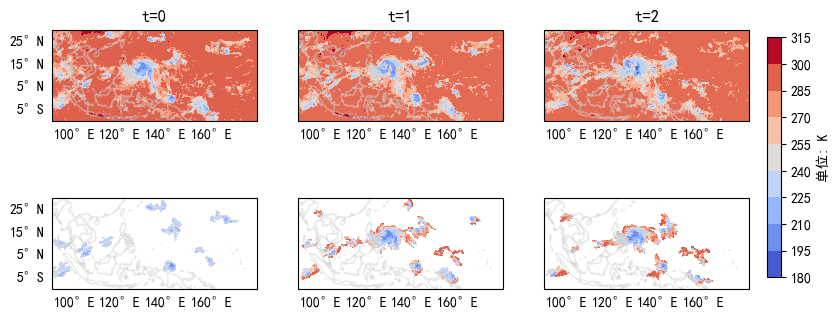

In [182]:
# 画图 
savepth = r'D:\00my_Github_Resp\02Atmos_graduate\MCS_recognition\img\test.png'
tackSubImg(tb_data_list,
           clean_otline_data,
           savepth,)


## 画出椭圆

In [184]:
min_list = []
max_list = []
new_data_list = []
for t, tbdata  in enumerate(tb_data_list):
    outline_mask = get_outline_contour(tbdata)
    new_data = np.where(outline_mask, tbdata, np.nan  ) 
    new_data_list.append(new_data)
    i_min = np.nanmin(new_data)
    i_max = np.nanmax(new_data)
    min_list.append(i_min)
    max_list.append(i_max)
min_list = np.array(min_list)
max_list = np.array(max_list)
print("最小：", min_list.min(), "最大：", max_list.max())


最小： 182.89 最大： 240.98999


In [186]:
# # 接着使用不同的函数 
# # lonlat_pts_list = outline2lonlat(mch_area_elip_list, lon , lat )
# data ,  datamask = get_dataAndmask(outline_mask, mch_area_elip_list, tb_data_list[0])



In [188]:
# # 在地图上绘制出椭圆
# _, binary_outline_mask = cv2.threshold(outline_mask, 127, 255, cv2.THRESH_BINARY)

# # 将二值图像转换为三通道图像以便画彩色椭圆
# binary_outline_mask_color = cv2.cvtColor(binary_outline_mask, cv2.COLOR_GRAY2BGR)

# # 在原图上绘制椭圆
# for cnt in mch_area_elip_list:
#     if len(cnt) >= 5:  # 确保有足够的点来拟合椭圆
#         ellipse = cv2.fitEllipse(cnt)
#         cv2.ellipse(binary_outline_mask_color, ellipse, color=(0, 0, 255), thickness=2)  # 使用红色绘制椭圆


# # 显示/保存结果
# cv2.imshow("Ellipses on Binary Outline Mask", binary_outline_mask_color)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
